In [1]:
import pandas as pd

labels = pd.read_sql_table('labels', 'sqlite:////home/sam/labeler/labels.sqlite')

In [3]:
print('Number of labels:', labels.shape[0])

labels.head()

Number of labels: 257


,id,document_id,label,labeler,labeler_ip
0,0,1216985,NaN,None,None
1,1,507947,33.0,None,None
2,2,650966,0.0,None,None
3,3,651052,38.0,None,None
4,4,366347,8.0,None,None


In [5]:
labels['is_syllabus'] = labels.label != 0

labels.is_syllabus.value_counts()

True     170
False     87
Name: is_syllabus, dtype: int64

In [35]:
import sqlalchemy
from sqlalchemy.orm import sessionmaker
from sqlalchemy.schema import MetaData

engine = sqlalchemy.create_engine('postgresql:///osp')
Session = sessionmaker(bind=engine)
session = Session()

metadata = MetaData()
metadata.reflect(bind=engine)

In [36]:
document_text_table = metadata.tables['document_text']

In [49]:
label_texts = []

for i, row in labels.iterrows():
    text = session.query(document_text_table).filter(document_text_table.c['document_id'] == row.document_id).first()[-1]
    label_texts.append(text)
    
labels['text'] = label_texts

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=100))
])

In [78]:
from sklearn.model_selection import cross_val_score

cross_val_score(text_clf, labels['text'].values, labels['is_syllabus'].values, cv=5, scoring='roc_auc')

array([ 0.97222222,  0.85784314,  0.84688581,  0.9083045 ,  0.94463668])

In [70]:
text_clf.fit(labels['text'].values, labels['is_syllabus'].values)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...mators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [77]:
results = []

text_cursor = session.query(document_text_table).yield_per(10).enable_eagerloads(False)

for i, (_, _, document_id, text) in enumerate(text_cursor):
    if i % 1000 == 0:
        print('.', end='')
    results.append((document_id, text_clf.predict_proba([text])[0][1]))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [82]:
results_df = pd.DataFrame(results, columns=['document_id', 'is_syllabus'])

In [83]:
print(results_df.shape)

results_df.head()

(1400513, 2)


,document_id,is_syllabus
0,1086299,0.395000
1,237602,0.566667
2,378931,0.883333
3,520119,0.583333
4,799669,0.810000


In [84]:
results_df.to_csv('/home/sam/data/osp/is_syllabus-preliminary.csv', index=False)

#### Now that we have a syllabus-not-syllabus classifier, let's do two things:

1. Look at syllabi closest to the decision boundary, and possibly use those to inform the next round of the classification.

2. Set a high threshold for `is_syllabus`, then apply a second classifier to the syllabi to sort into fields

In [86]:
results_df.is_syllabus.describe()

count    1.400513e+06
mean     6.476103e-01
std      2.607691e-01
min      3.333333e-03
25%      4.600000e-01
50%      7.383333e-01
75%      8.650000e-01
max      1.000000e+00
Name: is_syllabus, dtype: float64

In [92]:
sample = results_df.sample(100)

In [96]:
sample_texts = []

for i, document_id in enumerate(sample.document_id):
    text = session.query(document_text_table).filter(document_text_table.c['document_id'] == str(document_id)).first()[-1]
    sample_texts.append(text)

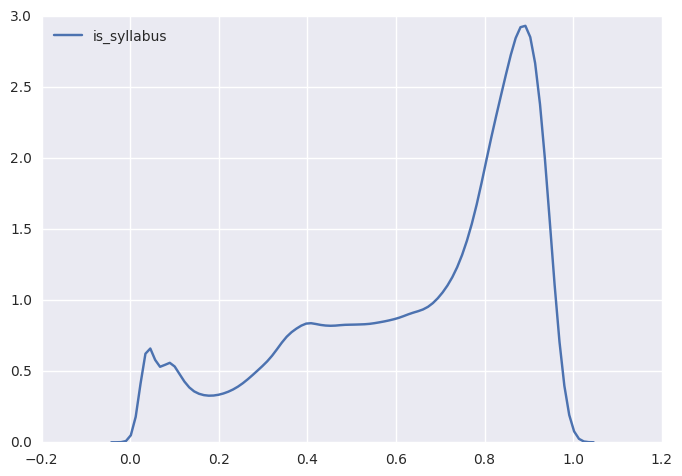

In [112]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(results_df.is_syllabus)

In [130]:
results_df[(results_df.is_syllabus > 0.53) & (results_df.is_syllabus < 0.58)].iloc[0]

document_id    237602.000000
is_syllabus         0.566667
Name: 1, dtype: float64

In [132]:
print(session.query(document_text_table).filter(document_text_table.c['document_id'] == str(237602)).first()[-1])





























JUN

OCT

DEC







20







2001

2002

2003







16 captures
2 Sep 00 - 29 Nov 09













Close
Help










FICTION OF POSTMODERN AMERICA:
COURSE OUTLINE & READING SCHEDULE






WEEK 1:  Tu Aug 24 -- INTRODUCTIONS & COURSE OVERVIEW

Th  Aug 26 -- MAPPING POSTMODERN & CONTEMPORARY AMERICAN LITERATURE(S)

REQUIRED READING:

 Paula Geyh, et al., eds, Postmodern American Fiction: A Norton Anthology (henceforth PAF) "Introduction" (pp. ix+)
Michael Berube, "Just the Fax M'am" (PAF 595+)

RECOMMENDED READING: 


WEEK 2:Tu  Aug 31 -- MAPPING POSTMODERNITIES

REQUIRED READING:
  Fredric Jameson, from "Postmodernism and Consumer Society." (PAF 654+)

 Donna Haraway, "A Cyborg Manifesto." (PAF 603+)
bell hooks, "Postmodern Blackness." (PAF 624+)
RECOMMENDED READING:
Neil Larsen,
"Postmodernism and Imperialism" (O)
Steven Best and Douglas Kellner,

Postmodern Theory: Critical InvestigationsWith excerpts on various postmodern theorists. (O)

Th  Sep 2 -- 